In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

import os
import numpy as np
import pandas as pd
import nitools as nt
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from SUITPy import flatmap
import PcmPy as pcm

import selective_recruitment.plotting as plotting
import selective_recruitment.globals as gl

import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as am
from statsmodels.stats.anova import AnovaRM  # perform F test
from selective_recruitment.scripts.script_roi_differences import norm_within_category,prep_roi_comparison, plot_roi_differences

import warnings
warnings.filterwarnings('ignore')


wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/srv/diedrichsen/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/Volumes/diedrichsen_data$/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'    
if not Path(wkdir).exists():
    wkdir = '/Users/jdiedrichsen/Data/wm_cerebellum/selective_recruit'

In [2]:

# sub_roi_list = ['6v', 'a9_46v', '46', 
#                 'IFJp', '6r', 'LIPv', 
#                 'MIP', 'IPS1', 'AIP', 
#                 'PFt', 'FST', 'POP4', 
#                 'SCEF', '7PL', 'v4', 
#                 'LO2', 'FEF', '6a']

# sub_roi_list = ["a9-46v", "p10p", "a10p", "11l", "a47r", 
#                     "p47r", "FOP5", "AVl", "6r", "IFJp", "8C", "p9-46v", 
#                     "i6-8", "s6-8", "AIP", "IP2", "IP1", 
#                     "LIPd", "MIP", "PGs", "PFm", "TE1m", "TE1p", 
#                     "POS2", "SCEF", "8BM", "a32pr", "d32"]

# keep the highest weight
sub_roi_list = ['IFJp', '6r', 'SCEF', '6ma'] # these regions were selected based on connectivity model, see: wm_paper_conn.ipynb

# keep the two highest weights
# sub_roi_list = ['IFJa', 'IFJp', '6r', 'i6-8', 'SCEF', 'PEF', '6ma', '6a']

# get the indices for the selected regions
roi_left = [f"L_{name}_ROI" for name in sub_roi_list]
roi_right = [f"R_{name}_ROI" for name in sub_roi_list]
roi_list = np.concatenate([roi_left, roi_right])

In [3]:
# df = ss.get_summary_data(dataset = "WMFS", 
#                         ses_id = 'ses-02', 
#                         atlas_space = "fs32k",
#                         atlas_roi = "glasser",
#                         type = "CondAll", 
#                         unite_struct = False,
#                         add_rest = True)
df = pd.read_csv(wkdir + '/glasser_df.csv')

In [4]:
# get a mask for selected rois
mask_list = np.isin(df.roi_name.values, roi_list)
D = df.loc[mask_list]
# add hemi label
D["hemi"] = D["roi_name"].str[0]

# get the name
D["roi_sub"] = D["roi_name"].str.split("_", expand = True)[1]
D = D.loc[D.hemi == "L"]
# D, cond_map = prep_roi_comparison(D)
cond_map = D[['cond_num','cond_name']].drop_duplicates()
cond_map.sort_values(by='cond_num', inplace=True)

D = norm_within_category(D, category=['roi_name','sn'], value='X', norm='z-score')


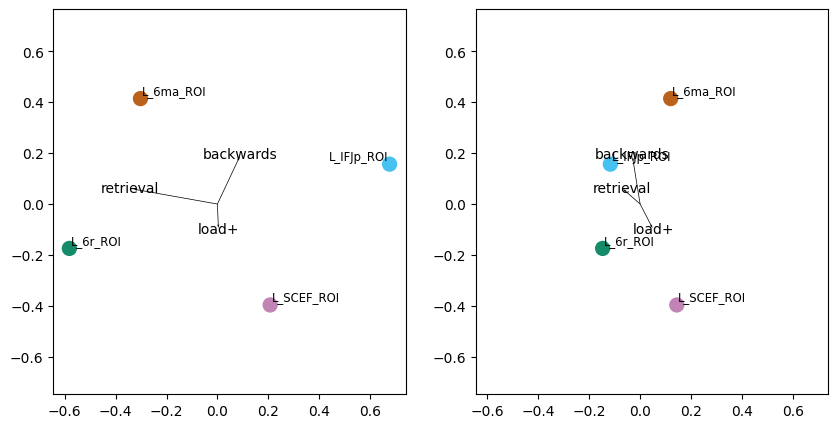

In [10]:

A = pd.pivot_table(data=D.loc[D.cond_name != "rest"],index='roi_name',columns='cond_name',values='X_norm',aggfunc=np.mean)
C=A.values
C=C/np.sqrt((C**2).sum(axis=1,keepdims=True))
B = C@C.T
K=3
W,V = plotting.calc_mds(A.values,K=K,center=True)
# phase, load, and recall
vs = np.array([[-1, 1,-1, 1,-1,1,-1,1,-1,1,-1,1],
                [-1,-1,0,0, 0,0, 0,0, 1,1, 0,0],
                [1,1, -1, -1, 1, 1, -1, -1,1,1, -1, -1]])
vs = vs/np.sqrt((vs**2).sum(axis=1,keepdims=True))
proj_vs = V @ vs.T

# just keep the highest weight
pal = ['#BA611BFF', # dark orange
       '#158B6AFF', # green
       '#45C2EFFF', # light blue
       '#C283B5FF', # purple 
        ]

# keep the two highest weights
# pal = ['#BA611BFF', # dark orange
#        '#BA611BFF', # dark orange
#        '#158B6AFF', # green
#        '#45C2EFFF', # light blue
#        '#45C2EFFF', # light blue 
#        '#C283B5FF', # purple
#        '#C283B5FF', # purple
#        '#158B6AFF', # green 
#         ]


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax1 = plotting.plot_mds(W[:,0],W[:,1],A.index,
                      colors=pal,
                      vectors=proj_vs[:2,:],
                      v_labels = ['retrieval','load+','backwards'])

plt.subplot(1,2,2, sharex=ax1)
ax2 = plotting.plot_mds(W[:,2],W[:,1],A.index,
                      colors=pal,
                      vectors=proj_vs[[2,1],:],
                      v_labels = ['retrieval','load+','backwards'])
# list of selected regions
# D1R	L_IFJp_ROI
# D2R	L_6r_ROI
# D3R	L_SCEF_ROI
# D4R	L_6ma_ROI

plt.savefig('mds_roi_cortex.pdf',dpi=300)

<!-- # list of selected regions
# D1R	L_IFJp_ROI
# D2R	L_6r_ROI
# D3R	L_SCEF_ROI
# D4R	L_6ma_ROI -->

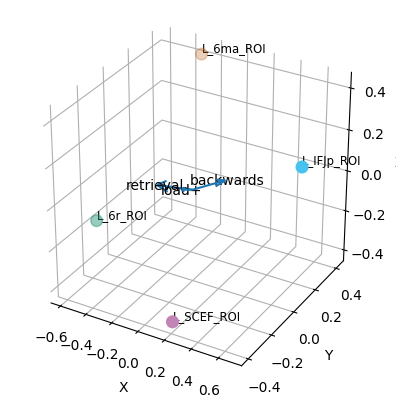

In [9]:
# %matplotlib qt
%matplotlib inline

plotting.plot_mds3(W[:,0],W[:,1], W[:,1], 
                   A.index, 
                   colors=pal,
                   text_size = 'small', 
                   text_weight = 'regular',
                   vectors = proj_vs,
                   v_labels = ['retrieval','load+','backwards'])

# plt.savefig('mds_roi_cortex_3d.pdf',dpi=300)